In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' 
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Reshape, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError

# for SNGP
import official.nlp.modeling.layers as nlp_layers

# for SNGP
import gpflow
import gpflux
from gpflow.config import default_float
from lib.spectral_normalization import SpectralNormalization

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae

from os import listdir
from os.path import isfile, join
from tqdm import tqdm


plt.rcParams.update({'font.size': 18})

In [2]:
mypath = 'N-CMAPSS_DL/N-CMAPSS/Samples_whole/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)

train_units = [2,5,10,16,18,20]
test_units = [11,14,15]

test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
train_files = list(set(onlyfiles) - set(test_files))
print(train_files)

['Unit5_win1_str1_smp500.npz', 'Unit2_win1_str1_smp500.npz', 'Unit16_win1_str1_smp500.npz', 'Unit10_win1_str1_smp500.npz', 'Unit18_win1_str1_smp500.npz', 'Unit20_win1_str1_smp500.npz', 'Unit11_win1_str1_smp500.npz', 'Unit14_win1_str1_smp500.npz', 'Unit15_win1_str1_smp500.npz']
['Unit20_win1_str1_smp500.npz', 'Unit5_win1_str1_smp500.npz', 'Unit18_win1_str1_smp500.npz', 'Unit16_win1_str1_smp500.npz', 'Unit10_win1_str1_smp500.npz', 'Unit2_win1_str1_smp500.npz']


In [3]:
def load_part_array_merge (current_dir, npz_units):
    sample_array_lst = []
    label_array_lst = []
    for npz_unit in npz_units:
      loaded = np.load(current_dir + npz_unit)
      sample_array_lst.append(loaded['sample'])
      label_array_lst.append(loaded['label'])
    sample_array = np.dstack(sample_array_lst)
    label_array = np.concatenate(label_array_lst)
    sample_array = sample_array.transpose(2, 0, 1)
    return sample_array, label_array

In [4]:
Xtrain_norm,Ytrain = load_part_array_merge(mypath,train_files)
Xtest_norm,Ytest = load_part_array_merge(mypath,test_files)
print(Xtrain_norm.shape)
Xtrain_norm = Xtrain_norm[:,0,:]
Xtest_norm = Xtest_norm[:,0,:]
Ytrain_norm = np.expand_dims((Ytrain)/np.max(Ytrain),1)
#Ytrain_norm = (Ytrain)/np.max(Ytrain)
Ytest_norm = np.expand_dims((Ytest)/np.max(Ytrain),1)
#Ytest_norm = (Ytest)/np.max(Ytrain)

(10527, 1, 20)


In [5]:
test_units = [11]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest11_norm,Ytest11 = load_part_array_merge(mypath,test_files)
Xtest11_norm = Xtest11_norm[:,0,:]
Ytest11_norm = np.expand_dims((Ytest11)/np.max(Ytrain),1)


test_units = [14]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest14_norm,Ytest14 = load_part_array_merge(mypath,test_files)
Xtest14_norm = Xtest14_norm[:,0,:]
Ytest14_norm = np.expand_dims((Ytest14)/np.max(Ytrain),1)


test_units = [15]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest15_norm,Ytest15 = load_part_array_merge(mypath,test_files)
Xtest15_norm = Xtest15_norm[:,0,:]
Ytest15_norm = np.expand_dims((Ytest15)/np.max(Ytrain),1)

In [6]:
# Get calibration curves
def get_confidence_interval(y_true, mu, sigma):
    alphas = np.linspace(1e-10, 1-1e-10, 1000)
    myCI=[]
    for myalpha in sorted(alphas):
        intervals = scipy.stats.norm.interval(alpha=myalpha, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        myCI.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    return 100*alphas, 100*np.array(myCI)  # converting to percentages


def get_rmse(y_true, y_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    Outputs:
    root mean squarred error
    """
    return np.sqrt(np.mean((y_true-y_pred)**2))

In [7]:
class FC_SNGP(tf.keras.Model):
    def __init__(self, no_outputs, spec_norm_bound=0.9, actfn = 'relu', **kwargs):
        super().__init__()
        self.actfn = actfn
        self.spec_norm_bound = spec_norm_bound
        self.kwargs = kwargs

        # hidden layers.
        self.dense_layers1 = nlp_layers.SpectralNormalization(self.make_dense_layer(100),
                                                              norm_multiplier=self.spec_norm_bound)
        self.dense_layers21 = nlp_layers.SpectralNormalization(self.make_dense_layer(100),
                                                              norm_multiplier=self.spec_norm_bound)
        self.dense_layers22 = nlp_layers.SpectralNormalization(self.make_dense_layer(100),
                                                              norm_multiplier=self.spec_norm_bound)
        self.dense_layers23 = nlp_layers.SpectralNormalization(self.make_dense_layer(100),
                                                              norm_multiplier=self.spec_norm_bound)
        self.dense_layers24 = nlp_layers.SpectralNormalization(self.make_dense_layer(100),
                                                              norm_multiplier=self.spec_norm_bound)
        self.dense_layers3 = nlp_layers.SpectralNormalization(self.make_dense_layer(10),
                                                              norm_multiplier=self.spec_norm_bound)
        # output layer.
        self.regressor = self.make_output_layer(no_outputs)

    def call(self, inputs, training=True, return_covmat=False):
        x = self.dense_layers1(inputs)
#         for _ in range(2):
        x = self.dense_layers21(x)
        x1 = self.dense_layers22(x)
        x = x1 + x
        x = self.dense_layers23(x)
        x1 = self.dense_layers24(x)
        x = x1 + x
        x = self.dense_layers3(x)
        mean = self.regressor(x)[0]
        variance = self.regressor(x)[1]
        if not training and return_covmat:
            return mean, variance
        
        return mean

    def make_dense_layer(self, hidden_units):
        """Use the Dense layer as the hidden layer."""
        return tf.keras.layers.Dense(hidden_units, activation=self.actfn)

    def make_output_layer(self, no_outputs):
        """Uses Gaussian process as the output layer."""
        return nlp_layers.RandomFeatureGaussianProcess(
            no_outputs,
            gp_cov_momentum=-1,
            gp_kernel_scale_trainable=True,
            #gp_output_bias_trainable=True,
            num_inducing=100,
            gp_kernel_scale=0.0001,
            **self.kwargs)

class ResetCovarianceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        """Resets covariance matrix at the beginning of the epoch."""
        if epoch > 0:
            self.model.regressor.reset_covariance_matrix()

class FC_SNGPWithCovReset(FC_SNGP):
    def fit(self, *args, **kwargs):
        """Adds ResetCovarianceCallback to model callbacks."""
        kwargs["callbacks"] = list(kwargs.get("callbacks", []))
        kwargs["callbacks"].append(ResetCovarianceCallback())
        return super().fit(*args, **kwargs)

In [8]:
def generate_trained_SNGPmodel(trainX, trainY, nepochs, actfn = 'sigmoid', spec_norm_bound = 0.9):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    spec_norm_bound - spectral normalization bounds
    Outputs:
    model   - trained SNGP model
    """
    loss = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

    model = FC_SNGPWithCovReset(no_outputs=1, spec_norm_bound = spec_norm_bound, actfn=actfn)
    model.compile(loss=loss, optimizer=optimizer)
    model.fit(trainX, trainY, batch_size=10, epochs=nepochs, verbose=1)
    return model

In [9]:
# single run

nepochs=100

dataset = ['train', 'test', 'test11', 'test14', 'test15']
model_SNGP = generate_trained_SNGPmodel(Xtrain_norm, Ytrain_norm, nepochs, 'relu', 0.9)
allresults_SNGPdf = pd.DataFrame()
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    result_df["SNGP_mu_eff"] = model_SNGP(Xnorm, training=False, return_covmat=True)[0]
    result_df["SNGP_sigma_eff"] = np.sqrt(tf.linalg.diag_part(
                                          model_SNGP(Xnorm, training=False, return_covmat=True)[1])[:, None]
                                         )
    allresults_SNGPdf = pd.concat([allresults_SNGPdf, result_df], axis = 0)

allresults_SNGPdf["SNGP_mu_eff"] = allresults_SNGPdf["SNGP_mu_eff"]*(np.max(Ytrain))
allresults_SNGPdf["SNGP_sigma_eff"] = allresults_SNGPdf["SNGP_sigma_eff"]*(np.max(Ytrain))



Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1053/1053 [==============================] - 6s 3ms/step - loss: 0.0635
Epoch 2/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0243
Epoch 3/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0170
Epoch 4/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0155
Epoch 5/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0133
Epoch 6/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0135
Epoch 7/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0121
Epoch 8/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0118
Epoch 9/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0121
Epoch 10/10
1053/1053 [=============================

In [10]:
print("Train RMSE: ", get_rmse(np.array(model_SNGP(Xtrain_norm, training=False,return_covmat=True)[0])[:,0]*(np.max(Ytrain)), Ytrain))
print("Test11 RMSE: ", get_rmse(np.array(model_SNGP(Xtest11_norm, training=False,return_covmat=True)[0])[:,0]*(np.max(Ytrain)), Ytest11))
print("Test14 RMSE: ", get_rmse(np.array(model_SNGP(Xtest14_norm, training=False,return_covmat=True)[0])[:,0]*(np.max(Ytrain)), Ytest14))
print("Test15 RMSE: ", get_rmse(np.array(model_SNGP(Xtest15_norm, training=False,return_covmat=True)[0])[:,0]*(np.max(Ytrain)), Ytest15))

Train RMSE:  8.447175
Test11 RMSE:  7.9605165
Test14 RMSE:  9.320882
Test15 RMSE:  6.1023655


In [11]:
model_train_bool = True
if model_train_bool:
    nmodels = 1 # total models trained and best one picked
    niter = 10

    allCI_SNGP = np.zeros((1000, niter))
    pbar=ProgressBar()
    allresults_SNGPdf = pd.DataFrame()

    for myiter in pbar(range(niter)): # for each independent iteration
        all_models_SNGP=[]
        all_rmse_train_SNGP = np.zeros(nmodels,)
        for i in range(nmodels): # train multiple models to select the best
            model_SNGP = generate_trained_SNGPmodel(Xtrain_norm, Ytrain_norm, nepochs, 'tanh', 0.9)
            all_rmse_train_SNGP[i] = get_rmse(np.array(model_SNGP(Xtrain_norm, training = False, 
                                                         return_covmat=True)[0])[:,0]*(np.max(Ytrain)), Ytrain)
        
            all_models_SNGP.append(model_SNGP)
        select_modelSNGP = all_models_SNGP[np.argmin(all_rmse_train_SNGP)] # best model

             
        for myset in dataset:
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            result_df["SNGP_mu_eff"] = select_modelSNGP(Xnorm, training=False, return_covmat=True)[0]
            result_df["SNGP_sigma_eff"] = np.sqrt(tf.linalg.diag_part(
                                          select_modelSNGP(Xnorm, training=False, return_covmat=True)[1])[:, None]
                                                 )
            result_df['iteration'] = myiter
            allresults_SNGPdf = pd.concat([allresults_SNGPdf, result_df], axis = 0)
               
    allresults_SNGPdf["SNGP_mu_eff"] = allresults_SNGPdf["SNGP_mu_eff"]*(np.max(Ytrain))
    allresults_SNGPdf["SNGP_sigma_eff"] = allresults_SNGPdf["SNGP_sigma_eff"]*(np.max(Ytrain))
    #allresults_SNGPdf.to_excel("results/SNGP_battery_prediction_results_new.xlsx")  
else:
    allresults_SNGPdf=pd.read_excel("results/SNGP_battery_prediction_results.xlsx")  

Epoch 1/10
1053/1053 [==============================] - 4s 3ms/step - loss: 0.1226
Epoch 2/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0323
Epoch 3/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0237
Epoch 4/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0191
Epoch 5/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0186
Epoch 6/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0162
Epoch 7/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0159
Epoch 8/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0157
Epoch 9/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0147
Epoch 10/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0144


Epoch 1/10
1053/1053 [==============================] - 4s 3ms/step - loss: 0.1583
Epoch 2/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.1130
Epoch 3/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0975
Epoch 4/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0577
Epoch 5/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0376
Epoch 6/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0277
Epoch 7/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0220
Epoch 8/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0172
Epoch 9/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0162
Epoch 10/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0153


Epoch 1/10
1053/1053 [==============================] - 4s 3ms/step - loss: 0.1802
Epoch 2/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.1049
Epoch 3/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0484
Epoch 4/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0301
Epoch 5/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0220
Epoch 6/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0181
Epoch 7/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0166
Epoch 8/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0158
Epoch 9/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0143
Epoch 10/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0140


Epoch 1/10
1053/1053 [==============================] - 4s 3ms/step - loss: 0.0772
Epoch 2/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0226
Epoch 3/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0199
Epoch 4/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0169
Epoch 5/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0152
Epoch 6/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0156
Epoch 7/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0147
Epoch 8/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0145
Epoch 9/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0133
Epoch 10/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0136


Epoch 1/10
1053/1053 [==============================] - 4s 3ms/step - loss: 0.1411
Epoch 2/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0509
Epoch 3/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0234
Epoch 4/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0183
Epoch 5/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0193
Epoch 6/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0162
Epoch 7/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0150
Epoch 8/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0138
Epoch 9/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0147
Epoch 10/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0134


Epoch 1/10
1053/1053 [==============================] - 5s 3ms/step - loss: 0.1075
Epoch 2/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0484
Epoch 3/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0312
Epoch 4/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0231
Epoch 5/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0207
Epoch 6/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0179
Epoch 7/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0170
Epoch 8/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0152
Epoch 9/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0154
Epoch 10/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0145


Epoch 1/10
1053/1053 [==============================] - 4s 3ms/step - loss: 0.0996
Epoch 2/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0273
Epoch 3/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0230
Epoch 4/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0204
Epoch 5/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0166
Epoch 6/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0179
Epoch 7/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0158
Epoch 8/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0159
Epoch 9/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0149
Epoch 10/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0144


Epoch 1/10
1053/1053 [==============================] - 7s 3ms/step - loss: 0.0860
Epoch 2/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0298
Epoch 3/10
1053/1053 [==============================] - 4s 3ms/step - loss: 0.0217
Epoch 4/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0181
Epoch 5/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0164
Epoch 6/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0157
Epoch 7/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0158
Epoch 8/10
1053/1053 [==============================] - 5s 4ms/step - loss: 0.0154
Epoch 9/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0138
Epoch 10/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0143


Epoch 1/10
1053/1053 [==============================] - 6s 4ms/step - loss: 0.0637
Epoch 2/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0270
Epoch 3/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0208
Epoch 4/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0190
Epoch 5/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0169
Epoch 6/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0157
Epoch 7/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0156
Epoch 8/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0148
Epoch 9/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0142
Epoch 10/10
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0141


Epoch 1/10
1053/1053 [==============================] - 6s 3ms/step - loss: 0.1488
Epoch 2/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0342
Epoch 3/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0207
Epoch 4/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0190
Epoch 5/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0181
Epoch 6/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0164
Epoch 7/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0141
Epoch 8/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0147
Epoch 9/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0142
Epoch 10/10
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0129


100% |##############################################################################################################################|


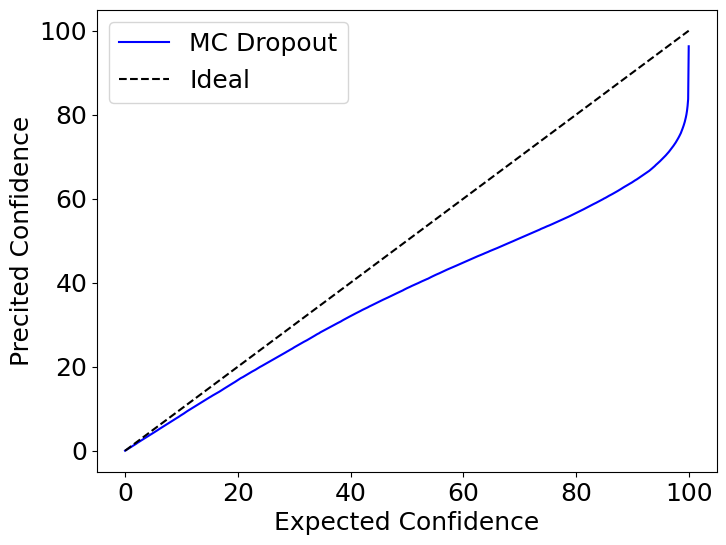

In [12]:
# plot the calibration curve
allresults_SNGPdf_train = allresults_SNGPdf.loc[allresults_SNGPdf['dataset']=='train']

alphas, CI_DE = get_confidence_interval(allresults_SNGPdf_train['True'].values, 
                                       allresults_SNGPdf_train['SNGP_mu_eff'].values, 
                                       allresults_SNGPdf_train['SNGP_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='MC Dropout')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()